<a href="https://colab.research.google.com/github/Ritvish/Fake_News_Detection/blob/main/RNN_with_Bidirectional_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading the libraries and Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install plotly
!pip install --upgrade nbformat
!pip install nltk
!pip install spacy # spaCy is an open-source software library for advanced natural language processing
!pip install WordCloud
!pip install gensim # Gensim is an open-source library for unsupervised topic modeling and natural language processing
!pip install jupyterthemes
import nltk
nltk.download('punkt')

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
# import keras
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 97.4 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
# load the data
df_true = pd.read_csv("/content/drive/MyDrive/MLNLP_PROJ/True.csv")
df_fake = pd.read_csv("/content/drive/MyDrive/MLNLP_PROJ/Fake.csv")

# EDA

In [5]:
df_true['isfake'] = 1
df_true.head()

df_fake['isfake'] = 0
df_fake.head()

# Concatenate Real and Fake News
df = pd.concat([df_true, df_fake]).reset_index(drop = True)
df.head()

,title,text,subject,date,isfake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [6]:
df.drop(columns = ['date'], inplace = True)

df['original'] = df['title'] + ' ' + df['text']
df.head()

,title,text,subject,isfake,original
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,Trump wants Postal Service to charge 'much mor...


# Data Cleaning

In [7]:
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
# Remove stopwords and remove words with 2 or less characters
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)

    return result

In [9]:
df['clean'] = df['original'].apply(preprocess)

In [10]:
#print cleaned news
print(df['clean'][0], '\n')

# Show original news
df['original'][0]

['budget', 'fight', 'looms', 'republicans', 'flip', 'fiscal', 'script', 'washington', 'reuters', 'head', 'conservative', 'republican', 'faction', 'congress', 'voted', 'month', 'huge', 'expansion', 'national', 'debt', 'cuts', 'called', 'fiscal', 'conservative', 'sunday', 'urged', 'budget', 'restraint', 'keeping', 'sharp', 'pivot', 'republicans', 'representative', 'mark', 'meadows', 'speaking', 'face', 'nation', 'drew', 'hard', 'line', 'federal', 'spending', 'lawmakers', 'bracing', 'battle', 'january', 'return', 'holidays', 'wednesday', 'lawmakers', 'begin', 'trying', 'pass', 'federal', 'budget', 'fight', 'likely', 'linked', 'issues', 'immigration', 'policy', 'november', 'congressional', 'election', 'campaigns', 'approach', 'republicans', 'seek', 'control', 'congress', 'president', 'donald', 'trump', 'republicans', 'want', 'budget', 'increase', 'military', 'spending', 'democrats', 'want', 'proportional', 'increases', 'defense', 'discretionary', 'spending', 'programs', 'support', 'educati

'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non

In [11]:
df.head()

,title,text,subject,isfake,original,clean
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t...","[budget, fight, looms, republicans, flip, fisc..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...,"[military, accept, transgender, recruits, mond..."
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,Senior U.S. Republican senator: 'Let Mr. Muell...,"[senior, republican, senator, mueller, washing..."
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,FBI Russia probe helped by Australian diplomat...,"[russia, probe, helped, australian, diplomat, ..."
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,Trump wants Postal Service to charge 'much mor...,"[trump, wants, postal, service, charge, amazon..."


In [12]:
# Obtaining the total words present in the dataset
list_of_words = []
for i in df.clean:
    for j in i:
        list_of_words.append(j)

In [13]:
len(list_of_words)

9276947

In [14]:
# Obtain the total number of unique words
total_words = len(list(set(list_of_words)))
total_words

108704

In [15]:
# join the words into a string
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))

In [16]:
df.head()

,title,text,subject,isfake,original,clean,clean_joined
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t...","[budget, fight, looms, republicans, flip, fisc...",budget fight looms republicans flip fiscal scr...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...,"[military, accept, transgender, recruits, mond...",military accept transgender recruits monday pe...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,Senior U.S. Republican senator: 'Let Mr. Muell...,"[senior, republican, senator, mueller, washing...",senior republican senator mueller washington r...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,FBI Russia probe helped by Australian diplomat...,"[russia, probe, helped, australian, diplomat, ...",russia probe helped australian diplomat washin...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,Trump wants Postal Service to charge 'much mor...,"[trump, wants, postal, service, charge, amazon...",trump wants postal service charge amazon shipm...


In [17]:
df['clean_joined'][0]

'budget fight looms republicans flip fiscal script washington reuters head conservative republican faction congress voted month huge expansion national debt cuts called fiscal conservative sunday urged budget restraint keeping sharp pivot republicans representative mark meadows speaking face nation drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy november congressional election campaigns approach republicans seek control congress president donald trump republicans want budget increase military spending democrats want proportional increases defense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration willing going increase defense discretionary spending percent meadows chairman small influential house freedom caucus said program democrats saying need government raise 

# Visualizing the cleaned up dataset

<Axes: xlabel='count', ylabel='subject'>

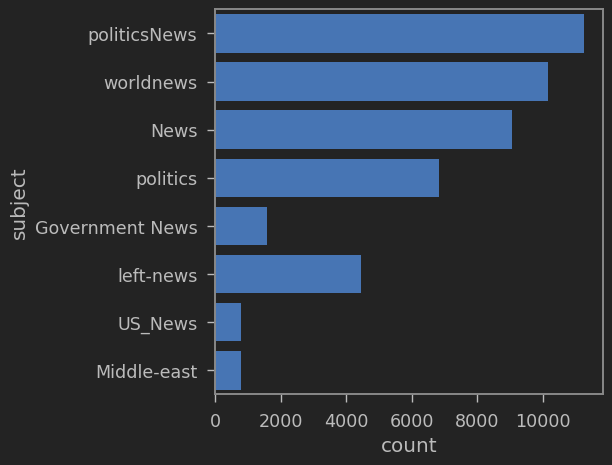

In [18]:
# plot the number of samples in 'subject'
plt.figure(figsize = (5, 5))
sns.countplot(y = "subject", data = df)

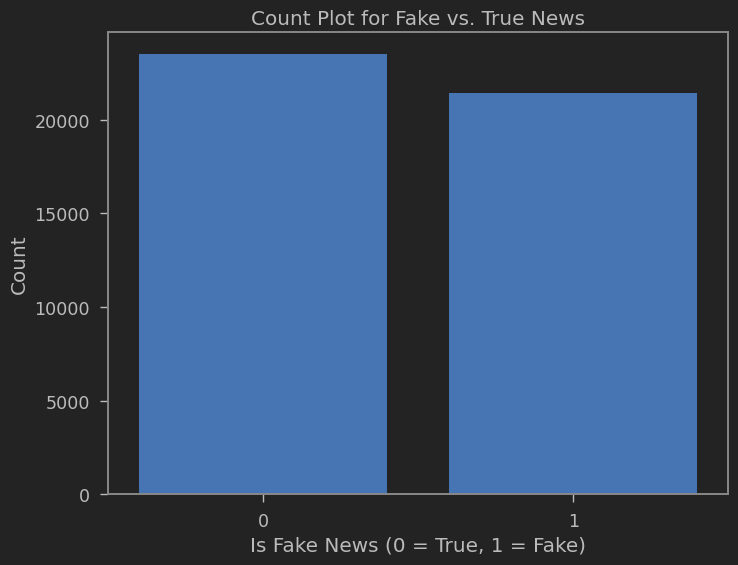

In [19]:
# ploting the count plot for fake vs. true news
plt.figure(figsize = (8, 6))
sns.countplot(x = 'isfake', data = df)
plt.title('Count Plot for Fake vs. True News')
plt.xlabel('Is Fake News (0 = True, 1 = Fake)')
plt.ylabel('Count')
plt.show()

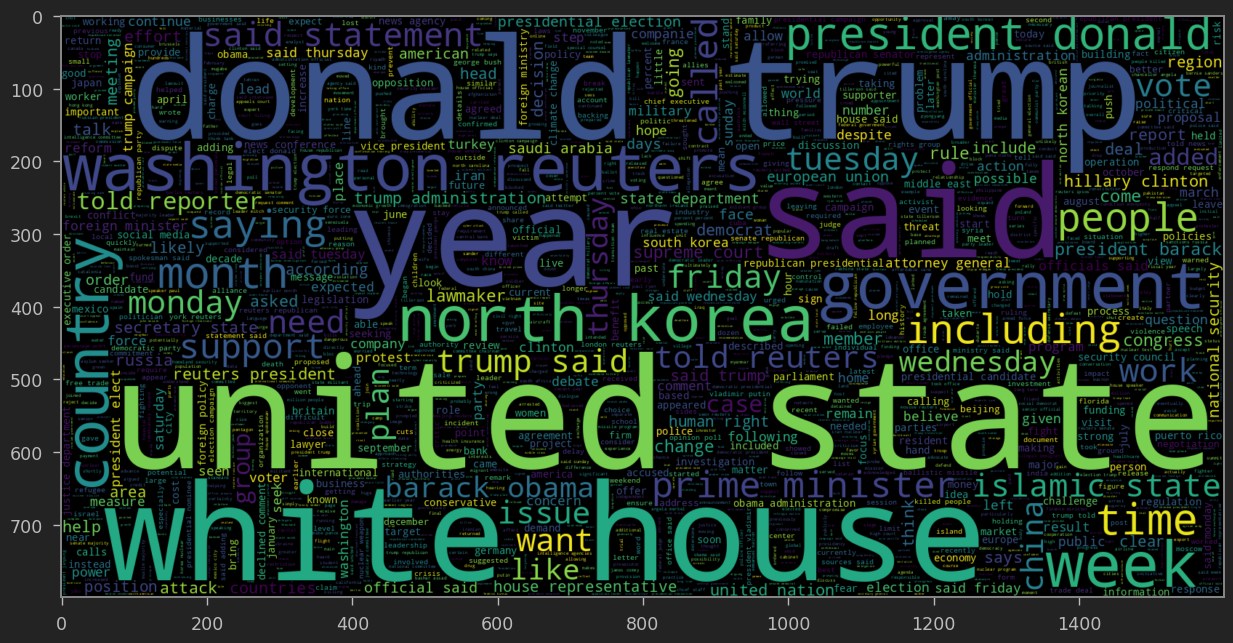

In [20]:
# plot the word cloud for text that is Real
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isfake == 1].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

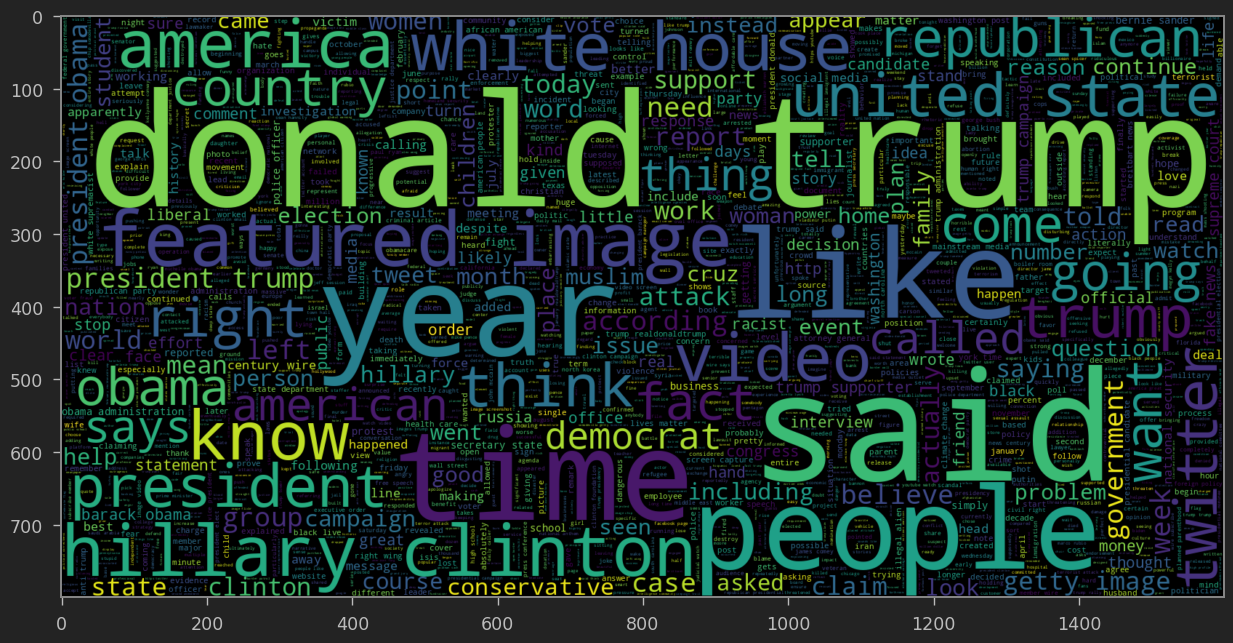

In [21]:
# plot the word cloud for text that is Fake
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isfake == 0].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

In [22]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [23]:
# length of maximum document will be needed to create word embeddings
maxlen = -1
for doc in df.clean_joined:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is =", maxlen)

The maximum number of words in any document is = 4405


In [24]:
# visualizing the distribution of number of words in a text
import plotly.express as px
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined], nbins = 100)
fig.show()

# Performing Tokenization and Padding

In [25]:
# spliting data into test and train
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.clean_joined, df.isfake, test_size = 0.2)

In [26]:
from nltk import word_tokenize
# Create a tokenizer to tokenize the words and create sequences of tokenized words
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

print("The encoding for document\n",df.clean_joined[0],"\n is : ",train_sequences[0])

The encoding for document
 budget fight looms republicans flip fiscal script washington reuters head conservative republican faction congress voted month huge expansion national debt cuts called fiscal conservative sunday urged budget restraint keeping sharp pivot republicans representative mark meadows speaking face nation drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy november congressional election campaigns approach republicans seek control congress president donald trump republicans want budget increase military spending democrats want proportional increases defense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration willing going increase defense discretionary spending percent meadows chairman small influential house freedom caucus said program democrats say

In [27]:
# Adding padding can either be maxlen = 4406 or smaller number maxlen = 40 seems to work well based on results
padded_train = pad_sequences(train_sequences,maxlen = 40, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences,maxlen = 40, truncating = 'post')

In [28]:
for i,doc in enumerate(padded_train[:2]):
     print("The padded encoding for document",i+1," is : ",doc)

The padded encoding for document 1  is :  [ 5727  1039  5487  1384  1089     9   231   244   140   875    48   429
  2279  8945   223   324   124   654   774    44  1579  1039    67 15034
  1384   603   450   957   429  1579   181     9    93  5539  1039  1303
    10  4938   187  1083]
The padded encoding for document 2  is :  [  859     3     1   423  1074   307  1340    27     3     1  2529  3015
  7447   147     3   373  1074   468    77  2610  3015  7447 16305  4892
   147   558  1108   859  2179 10246  3015  7447   147 18772  4634    39
 49682  2311 21228 21229]


# Building the RNN Model with Bidirectional LSTM

In [29]:
# Sequential Model
model = Sequential()

# embeddidng layer
model.add(Embedding(total_words, output_dim = 128))
# model.add(Embedding(total_words, output_dim = 240))


# Bi-Directional RNN and LSTM
model.add(Bidirectional(LSTM(128)))

# Dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1,activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [30]:
total_words

108704

In [31]:
y_train = np.asarray(y_train)

In [32]:
# train the model
model.fit(padded_train, y_train, batch_size = 64, validation_split = 0.1, epochs = 2)

Epoch 1/2
506/506 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - acc: 0.9425 - loss: 0.1093 - val_acc: 0.9986 - val_loss: 0.0064
Epoch 2/2
506/506 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - acc: 0.9996 - loss: 0.0020 - val_acc: 0.9989 - val_loss: 0.0075


# Making predictions and Evaluting Accuracy of the model

In [33]:

pred = model.predict(padded_test)

281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [34]:

prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

# getting the accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), prediction)

print("Model Accuracy : ", accuracy)

Model Accuracy :  0.9956570155902005


<Axes: >

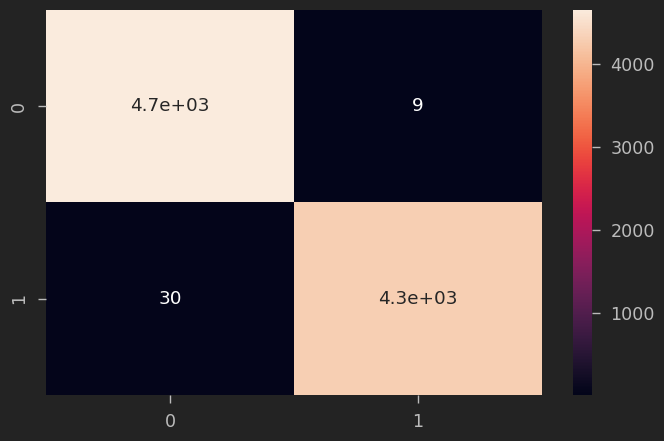

In [35]:
# getting the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True)